In [1]:
import numpy as np
import pandas as pd
import datetime
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt, numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import AgglomerativeClustering
from matplotlib.colors import ListedColormap
from sklearn import metrics
import warnings
import sys

In [2]:
data = pd.read_csv('city_foreign.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40190 entries, 0 to 40189
Data columns (total 24 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   is_canceled                     40190 non-null  int64  
 1   lead_time                       40190 non-null  int64  
 2   arrival_date_year               40190 non-null  int64  
 3   arrival_date_month              40190 non-null  object 
 4   arrival_date_day_of_month       40190 non-null  int64  
 5   stays_in_weekend_nights         40190 non-null  int64  
 6   stays_in_week_nights            40190 non-null  int64  
 7   adults                          40190 non-null  int64  
 8   children                        40190 non-null  float64
 9   babies                          40190 non-null  int64  
 10  meal                            40190 non-null  object 
 11  market_segment                  40190 non-null  object 
 12  is_repeated_guest               

In [4]:
numeric_columns = data.select_dtypes(include=['number'])
catergoric_columns = data.select_dtypes(include=['object'])
numerical_vars = list(numeric_columns.columns)
categorical_vars = list(catergoric_columns.columns)

In [5]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import pandas as pd


# Split categorical variables into label encoded and one-hot encoded
label_encoded_vars = ['arrival_date_month', 'reserved_room_type']
one_hot_encoded_vars = list(set(categorical_vars) - set(label_encoded_vars))

data_selected = data[numerical_vars + categorical_vars]

# Label encode the specified columns
label_encoders = {}
for col in label_encoded_vars:
    le = LabelEncoder()
    data_selected[col] = le.fit_transform(data_selected[col])
    label_encoders[col] = le

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_vars),
        ('label', 'passthrough', label_encoded_vars),   # Just pass the label encoded columns through
        ('onehot', OneHotEncoder(drop='first'), one_hot_encoded_vars)])

data_preprocessed = preprocessor.fit_transform(data_selected)

ohe_categories = preprocessor.named_transformers_['onehot'].categories_
new_ohe_features = [
    f"{col}_{val}" for col, vals in zip(one_hot_encoded_vars, ohe_categories) for val in vals[1:]
]

all_feature_names = numerical_vars + label_encoded_vars + new_ohe_features

data_processed_df = pd.DataFrame(data_preprocessed, columns=all_feature_names)

data_processed_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40190 entries, 0 to 40189
Data columns (total 33 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   is_canceled                     40190 non-null  float64
 1   lead_time                       40190 non-null  float64
 2   arrival_date_year               40190 non-null  float64
 3   arrival_date_day_of_month       40190 non-null  float64
 4   stays_in_weekend_nights         40190 non-null  float64
 5   stays_in_week_nights            40190 non-null  float64
 6   adults                          40190 non-null  float64
 7   children                        40190 non-null  float64
 8   babies                          40190 non-null  float64
 9   is_repeated_guest               40190 non-null  float64
 10  previous_cancellations          40190 non-null  float64
 11  previous_bookings_not_canceled  40190 non-null  float64
 12  booking_changes                 

# Dimensionality Reduction

In [6]:
from sklearn.decomposition import PCA
import numpy as np

pca = PCA(n_components=3)
pca.fit(data_processed_df)
PCA_ds = pd.DataFrame(pca.transform(data_processed_df), columns=(["col1","col2", "col3"]))
PCA_ds.describe().T


,count,mean,std,min,25%,50%,75%,max
col1,40190.0,3.948361e-15,3.491234,-5.684073,-3.188742,-0.126605,2.713659,6.195924
col2,40190.0,-1.832340e-14,1.872631,-4.573145,-1.286173,-0.793285,1.413210,7.330875
col3,40190.0,1.752408e-14,1.438748,-1.322807,-0.298254,-0.130005,0.073012,34.371798


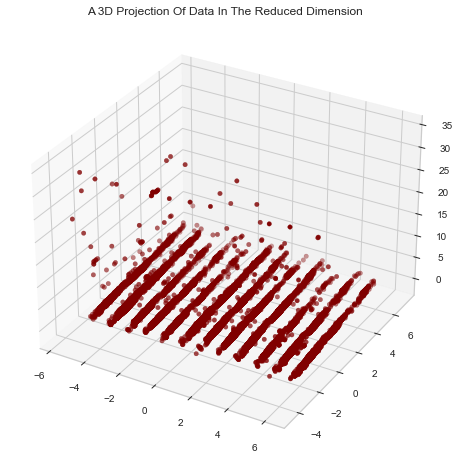

In [7]:
#A 3D Projection Of Data In The Reduced Dimension
x =PCA_ds["col1"]
y =PCA_ds["col2"]
z =PCA_ds["col3"]
#To plot
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x,y,z, c="maroon", marker="o" )
ax.set_title("A 3D Projection Of Data In The Reduced Dimension")
plt.show()

# Clustering

Elbow Method to determine the number of clusters to be formed:


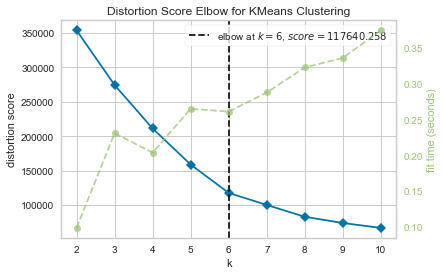

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [8]:
# Quick examination of elbow method to find numbers of clusters to make.
print('Elbow Method to determine the number of clusters to be formed:')
Elbow_M = KElbowVisualizer(KMeans(), k=10)
Elbow_M.fit(PCA_ds)
Elbow_M.show()

In [9]:
#Initiating the Agglomerative Clustering model 
AC = AgglomerativeClustering(n_clusters=6)
# fit model and predict clusters
yhat_AC = AC.fit_predict(PCA_ds)
PCA_ds["Clusters"] = yhat_AC
#Adding the Clusters feature to the orignal dataframe.
data["Clusters"]= yhat_AC

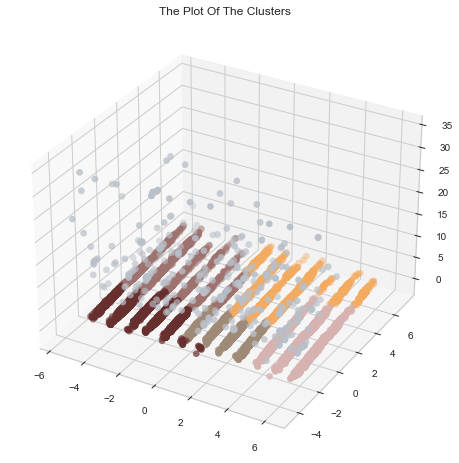

In [10]:
#Plotting the clusters
cmap = colors.ListedColormap(["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"])
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(x, y, z, s=40, c=PCA_ds["Clusters"], marker='o', cmap = cmap )
ax.set_title("The Plot Of The Clusters")
plt.show()

# Model Evaluation

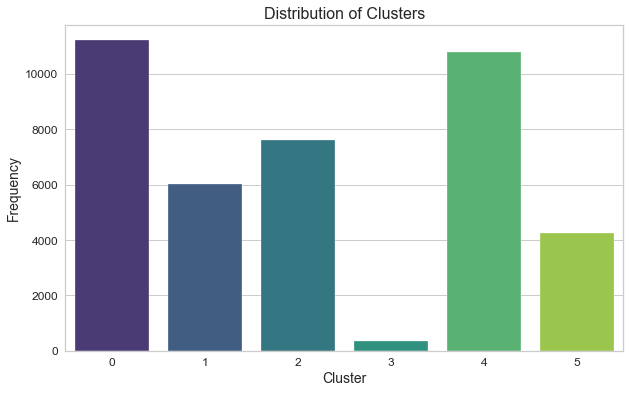

In [11]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Initialize the matplotlib figure
plt.figure(figsize=(10, 6))

# Count the frequency of each cluster
cluster_count = data['Clusters'].value_counts()

# Create a bar plot for the clusters
sns.barplot(x=cluster_count.index, y=cluster_count.values, palette="viridis")

# Adding titles and labels
plt.title('Distribution of Clusters', fontsize=16)
plt.xlabel('Cluster', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Display the plot
plt.show()

# Profiling The Clusters

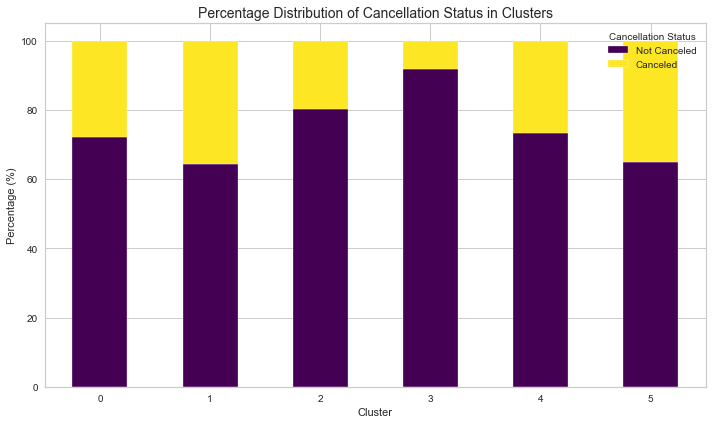

In [12]:
import matplotlib.pyplot as plt

# Grouping by 'Clusters' and 'is_canceled', and calculating the percentage within each cluster
cluster_cancellation_percentage = (data.groupby(['Clusters', 'is_canceled']).size() / data.groupby('Clusters').size()) * 100
cluster_cancellation_percentage = cluster_cancellation_percentage.unstack().fillna(0)

# Creating a stacked bar plot
ax = cluster_cancellation_percentage.plot(kind='bar', stacked=True, colormap='viridis', figsize=(10, 6), rot=0)

# Adding labels and title
ax.set_title('Percentage Distribution of Cancellation Status in Clusters', fontsize=14)
ax.set_xlabel('Cluster')
ax.set_ylabel('Percentage (%)')
ax.legend(title='Cancellation Status', labels=['Not Canceled', 'Canceled'], loc='upper right')

# Display the plot
plt.tight_layout()
plt.show()


ValueError: Could not interpret input 'total_rate'

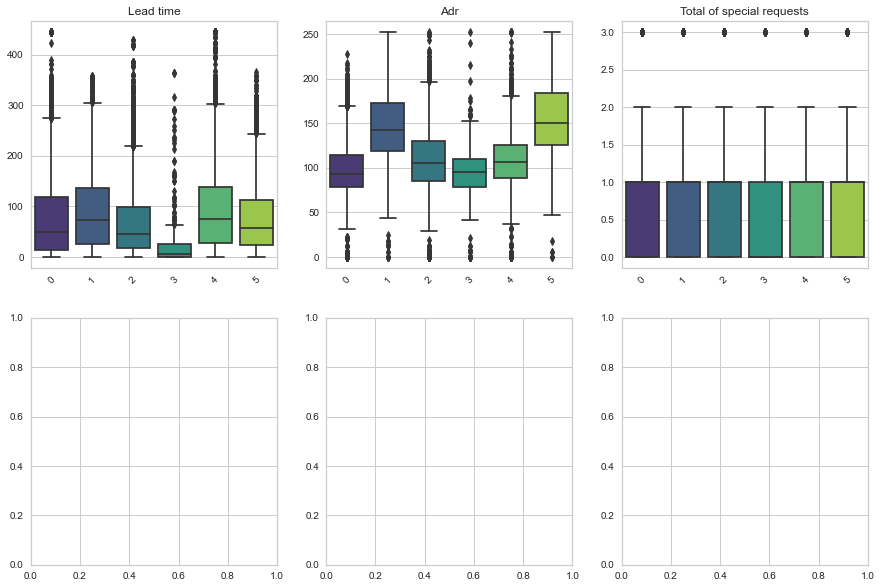

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the selected numerical features
numerical_features = ['lead_time', 'adr','total_of_special_requests', 'total_rate', 'total_stay_nights',
        'total_guests']

# Determine the layout for the subplots
num_features = len(numerical_features)
num_cols = 3  # Define the number of columns for the layout
num_rows = -(-num_features // num_cols)  # Calculate the number of rows needed, round up

# Set up the matplotlib figure and axes
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))
axes = axes.flatten()  # Flatten the 2D array of axes into 1D

# Loop through the numerical features and create box plots
for i, feature in enumerate(numerical_features):
    sns.boxplot(ax=axes[i], x='Clusters', y=feature, data=data, palette='viridis')
    axes[i].set_title(feature.capitalize().replace('_', ' '))
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', rotation=45)

# Adjust layout and display the plots
plt.tight_layout()
plt.show()


In [14]:
data_cluster_0 = data[data['Clusters'] == 0]
data_cluster_1 = data[data['Clusters'] == 1]
data_cluster_2 = data[data['Clusters'] == 2]
data_cluster_3 = data[data['Clusters'] == 3]
data_cluster_4 = data[data['Clusters'] == 4]
data_cluster_5 = data[data['Clusters'] == 5]

In [15]:
cluster_0 = data_cluster_0.describe().median()
cluster_1 = data_cluster_1.describe().median()
cluster_2 = data_cluster_2.describe().median()
cluster_3 = data_cluster_3.describe().median()
cluster_4 = data_cluster_4.describe().median()
cluster_5 = data_cluster_5.describe().median()

In [16]:
df_clusters = pd.DataFrame([cluster_0, cluster_1, cluster_2, cluster_3, cluster_4, cluster_5])
df_clusters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   is_canceled                     6 non-null      float64
 1   lead_time                       6 non-null      float64
 2   arrival_date_year               6 non-null      float64
 3   arrival_date_day_of_month       6 non-null      float64
 4   stays_in_weekend_nights         6 non-null      float64
 5   stays_in_week_nights            6 non-null      float64
 6   adults                          6 non-null      float64
 7   children                        6 non-null      float64
 8   babies                          6 non-null      float64
 9   is_repeated_guest               6 non-null      float64
 10  previous_cancellations          6 non-null      float64
 11  previous_bookings_not_canceled  6 non-null      float64
 12  booking_changes                 6 non-nu

ValueError: The number of FixedLocator locations (4), usually from a call to set_ticks, does not match the number of ticklabels (6).

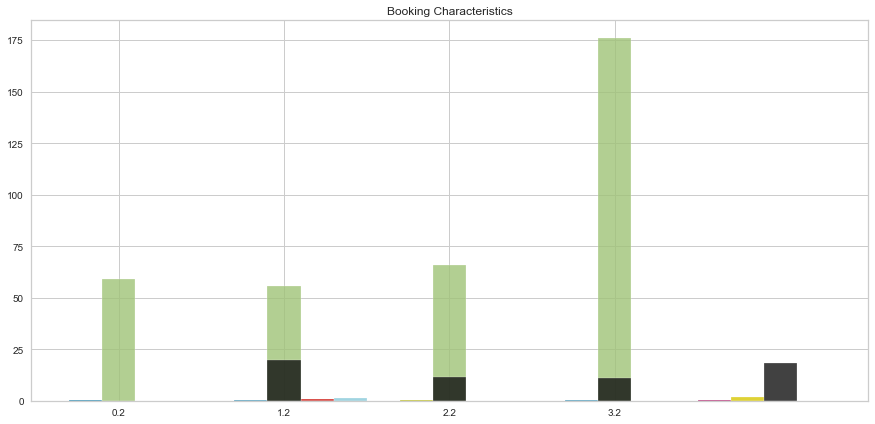

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Data
clusters = ["Cluster 0", "Cluster 1", "Cluster 2", "Cluster 3", "Cluster 4", "Cluster 5"]

# Booking Characteristics
booking_characteristics = {
    'is_canceled': [0.358596, 0.444835, 0.368033, 0.451194],
    'lead_time': [59.198518, 55.566022, 65.688801, 175.772291],
    'previous_cancellations': [0.000000, 0.779131, 0.000000, 0.000000],
    'previous_bookings_not_canceled': [0.000295, 1.407614, 0.005481, 0.001052],
    'booking_changes': [0.104623, 0.113181, 0.104715, 0.182009],
    'days_in_waiting_list': [0.135076, 0.302770, 0.000773, 1.798724],
    'agent': [19.581541, 11.664756, 10.832907, 18.455944],
    'required_car_parking_spaces': [0.000000, 0.056829, 0.055384, 0.000723]
}

# Guest Characteristics
guest_characteristics = {
    'adults': [1.863867, 1.190544, 2.000000, 2.000000],
    'children': [0.007578, 0.013849, 0.553625, 0.034521],
    'is_repeated_guest': [0.003833, 0.819484, 0.004338, 0.000592],
    'total_guests': [1.871445, 1.204394, 2.801231, 2.000000]
}

# Stay Characteristics
stay_characteristics = {
    'stays_in_weekend_nights': [0.736415, 0.677019, 0.941186, 1.785508],
    'stays_in_week_nights': [1.932349, 1.487345, 2.138173, 3.949040],
    'total_stay_nights': [2.279221, 2.107450, 3.079360, 5.234548]
}

# Pricing and Services
pricing_services = {
    'adr': [95.889725, 69.974214, 145.720340, 100.913209],
    'total_of_special_requests': [0.516664, 0.755120, 1.102731, 0.928270],
    'total_rate': [238.576488, 177.458804, 441.843406, 530.176037]
}

# Function to plot bar charts for each category
def plot_bars(data_dict, title):
    n_clusters = 4
    n_features = len(data_dict)
    bar_width = 0.2
    index = np.arange(n_clusters)
    
    fig, ax = plt.subplots(figsize=(15, 7))
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'lightgray']
    
    for i, (feature, values) in enumerate(data_dict.items()):
        plt.bar(index + i * bar_width, values, bar_width, alpha=0.8, color=colors[i], label=feature)
        
    plt.title(title)
    plt.xticks(index + bar_width, clusters)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plotting the bar charts
plot_bars(booking_characteristics, 'Booking Characteristics')
plot_bars(guest_characteristics, 'Guest Characteristics')
plot_bars(stay_characteristics, 'Stay Characteristics')
plot_bars(pricing_services, 'Pricing and Services')


## Booking Characteristics:
- is_canceled: Clusters 1 and 3 have a higher median cancellation rate, which could indicate that they might be more impulsive or uncertain guests.
- lead_time: Cluster 3 guests book way ahead of time (median of 175 days), while the other clusters have a lead time of around 55-65 days.
- previous_cancellations: Cluster 1 guests have a notably higher median of previous cancellations.
- previous_bookings_not_canceled: Again, Cluster 1 stands out with a higher median.
- booking_changes: Cluster 3 guests are slightly more likely to make changes to their bookings.
- days_in_waiting_list: Cluster 3 guests have waited more days on average, which is consistent with their longer lead time.
- agent: Clusters 0 and 3 seem to be booking through a similar agent (based on the median value), which might indicate they're from a similar source or platform.
- required_car_parking_spaces: Cluster 1 and 2 guests occasionally require parking, while others rarely do.

## Guest Characteristics:
- adults: Cluster 2 and 3 have a median of 2 adults, while Cluster 1 mainly consists of solo guests.
- children: Cluster 2 guests are more likely to bring children.
- babies: None of the clusters have a notable median number of babies.
- is_repeated_guest: Cluster 1 has a significantly higher rate of repeated guests.
- total_guests: Cluster 2 guests have the highest median total number of guests.


## Stay Characteristics:
- arrival_date_year: There's not much difference among clusters. However, Cluster 1 guests seem to have booked slightly earlier in the year.
- arrival_date_week_number & arrival_date_day_of_month: No significant pattern observed.
- stays_in_weekend_nights & stays_in_week_nights: Cluster 3 guests tend to stay longer in both weekend and weekdays.
- total_stay_nights: Cluster 3 guests have the longest stays, with a median of over 5 nights.

## Pricing and Services:
- adr: Cluster 2 guests pay the highest average daily rate.
- total_of_special_requests: Cluster 2 guests also make the most special requests.
- total_rate: Cluster 3 guests have the highest total rate, which aligns with their longer stays.

## Insights:

- Cluster 0: Represents typical guests, with average characteristics across all parameters.
- Cluster 1: Represents repeated guests, with prior booking and cancellation history. They are mostly solo guests.
- Cluster 2: Represents families (given the presence of children), who spend more and ask for more special requests.
- Cluster 3: Represents guests who plan their trips well in advance, stay longer, and consequently have a higher total rate.


## Conclusion:
Each clusers represent the different groups og guests, thus taking into their characteristics in to consideration implement appropriate marketing strategy to the respecifve Clusters.